# Plots for the thesis

In [1]:
import os
import sys

import time 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from matplotlib.lines import Line2D
from copy import deepcopy

from predCoding import * # in particular, import: pc_model, spikeMod_sim, rateMod_sim
from utils import *
from plot_utils import *

plt.rcParams['figure.figsize'] = [full_width,2/3* full_width]
plt.rcParams['figure.dpi'] = 100


In [2]:
default_params = {'nNeur' :   100, 
                  'ratePosWeights' : 0.5,
                  'lambd' :    0.05, # time constant 1/lambda should be around 20ms
                  'sigma_V' :  1,
                  'linCost' :  1,
                  'quadCost' : 1,
                  'connStrength' : 5,
                 'tau': 5}

def input_cst(t,strength=1): return strength/20+0*t
default_input = input_cst

default_spikeMod = {**default_params,
                    'input_fct': default_input, 
                    'T': 200, 
                    't_step': 0.01}

# to modify parameters easily 
def setPar(d=None,**kwargs):
    if d  is None:                                
        d=dict(**default_spikeMod)
    for key, arg in kwargs.items():
        d[key]=arg
    return d

In [3]:
# for individual adjustments
SAVEFIG_PATH=''

## LIF transfer function

In [4]:
grid_phi=np.arange(-0.2,0.3,0.001)
phi_res=[]
der_phi_res=[]
sig_vals=[0.5,1,1.5]
for i,sig in enumerate(sig_vals): 
    phi_res.append(lif_transferFct(grid_phi,lambd=1/20,sigma_V=sig,Vthr=1,Vreset=-0.2))
    der_phi_res.append(v_lif_tr_fct_der(grid_phi,lambd=1/20,sigma_V=sig,Vthr=1,Vreset=-0.2))
    

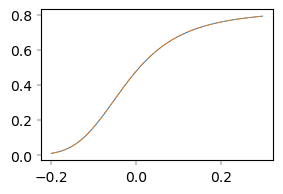

In [5]:
plt.rcParams.update({'text.usetex':True})
plt.figure(figsize=[3,2])
fd_lif = (phi_res[i][1:]-phi_res[i][:-1])/0.001
plt.plot(grid_phi,der_phi_res[i], label='LIF')
plt.plot(grid_phi[:-1],fd_lif,'-.',label='Finite differenes')

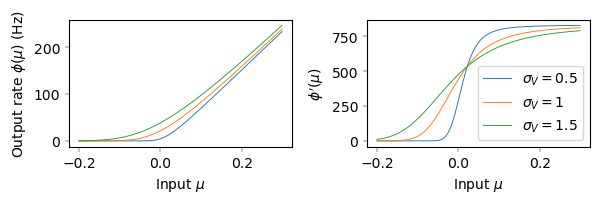

In [6]:
plt.figure(figsize=[full_width,full_width/3])

ax1=plt.subplot(1,2,1)
ax1.set_ylabel(r'Output rate $\phi(\mu)$ (Hz)')
ax2=plt.subplot(1,2,2)
ax2.set_ylabel(r'$\phi^\prime(\mu)$')
ax1.set_xlabel(r'Input $\mu$')
ax2.set_xlabel(r'Input $\mu$')
for i,sig in enumerate(sig_vals):
    ax1.plot(grid_phi, 1000*phi_res[i], label=fr'$\sigma_V={sig}$')
    #
    ax2.plot(grid_phi, 1000*der_phi_res[i], label=fr'$\sigma_V={sig}$')

plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'lif_transfer_fct'),bbox_inches='tight')

# Toy model

In [7]:
def step_fct(t,strength=0.1): return (t>30)*strength # hist: 0.1 (too strong)

spikeM_toy1=spikeMod_sim(**setPar(nNeur=2,input_fct=step_fct,t_step=0.01, sigma_V=0,
                            T=130,tau=10,connStrength=1,linCost=1,quadCost=1,balance=False,randInit=False,sparse=False))

In [8]:
spikeM_toy2=spikeMod_sim(**setPar(nNeur=2,input_fct=lambda t:step_fct(t,0.1),t_step=0.01, sigma_V=0,
                            T=130,tau=10,connStrength=1,balance=False,linCost=0,quadCost=0),randInit=False)

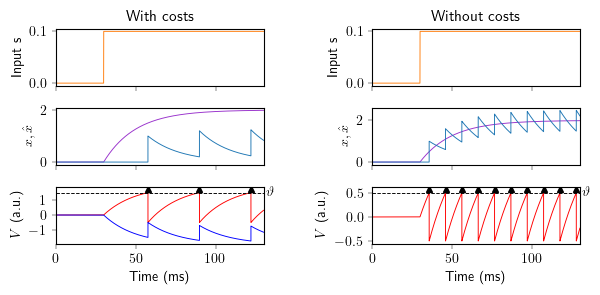

In [9]:
fig, axs=plt.subplots(3,2, sharex='col',figsize=[full_width,1/2*full_width],dpi=100)
plot_input(spikeM_toy1,ax=axs[0,0])
axs[0,0].set_title('With costs')
plotNetPerf(spikeM_toy1,ax=axs[1,0],show_title=False,show_label_ax='y',show_legend=False)
plotSampleVm(spikeM_toy1,ax=axs[2,0],show_legend=False,msize=5,moffset=0.15)
axs[2,0].set_title('')

plot_input(spikeM_toy2,ax=axs[0,1])
axs[0,1].set_title('Without costs')
plotNetPerf(spikeM_toy2,ax=axs[1,1],show_title=False,show_label_ax='y',show_legend=False) #axs[1,1].set_ylabel('')
plotSampleVm(spikeM_toy2,ax=axs[2,1],show_legend=False,msize=5,pos_only=True,moffset=0.15)
axs[2,1].set_title('')
plt.tight_layout(w_pad=3)
#plt.savefig(os.path.join(SAVEFIG_PATH,'toy_model'),bbox_inches='tight',dpi=300)   

# Sample case: 1D model with binary weights

In [10]:
input_no_scaling=lambda t: input_cst(t,strength=5)
spikeM_noScaling=spikeMod_sim(**setPar(balance=False,T=500,linCost=1,quadCost=1,input_fct=input_no_scaling,connStrength=0.5,
                             sigma_V=0.5))
input_cos_no_scaling=lambda t: 0.5*np.cos(0.05*t)
spikeM_cos_noScaling=spikeMod_sim(**setPar(balance=False,T=500,linCost=1,quadCost=1,input_fct=input_cos_no_scaling,
                                           connStrength=0.5,sigma_V=0.5))



In [11]:
%%time
spikeM_noScaling2=spikeMod_sim(**setPar(balance=False,T=20000,linCost=1,quadCost=1,
                                              input_fct=input_no_scaling,connStrength=0.5,sigma_V=0.5))
cv(spikeM_noScaling2)

CPU times: user 1min 13s, sys: 3.15 s, total: 1min 16s
Wall time: 1min 18s


0.9588060651904933

In [12]:
del spikeM_noScaling2

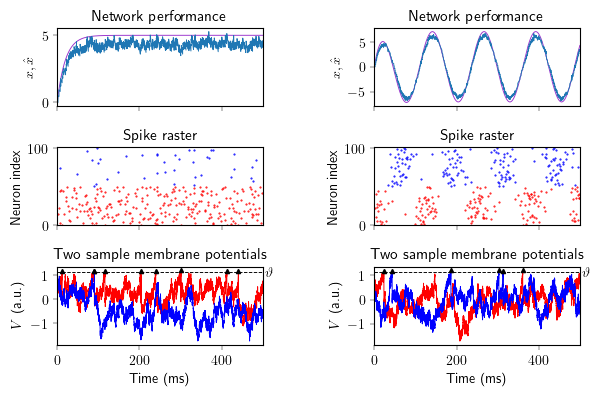

In [13]:
fig, axs=plt.subplots(3,2, sharex=True,figsize=[full_width,2/3*full_width],dpi=100)
plotNetPerf(spikeM_noScaling,ax=axs[0,0],show_label_ax='y',show_legend=False)
plotFirTimes(spikeM_noScaling,ax=axs[1,0],show_label_ax='y',show_legend=False)
plotSampleVm(spikeM_noScaling,ax=axs[2,0],show_legend=False,msize=3)

plotNetPerf(spikeM_cos_noScaling,ax=axs[0,1],show_label_ax='y',show_legend=False)
plotFirTimes(spikeM_cos_noScaling,ax=axs[1,1],show_label_ax='y',show_legend=False)
plotSampleVm(spikeM_cos_noScaling,ax=axs[2,1],show_legend=False,msize=3)
plt.tight_layout(w_pad=4)
fig.add_subplot(111,frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

#plt.savefig(os.path.join(SAVEFIG_PATH,'sample1d_diff_s1'),bbox_inches='tight',dpi=300)   

# Scaling with $N \rightarrow \infty$

Default scaling

In [14]:
input_cos_scal=lambda t: 0.5*np.cos(0.1*t)

In [15]:
Nscal_pars1={'input_fct': input_cos_scal,'connStrength':3.5,'sigma_V': 1}
spikeM_sc1=spikeMod_sim(**setPar(nNeur=100,**Nscal_pars1))
spikeM_sc1_1k=spikeMod_sim(**setPar(nNeur=1000,**Nscal_pars1))
spikeM_sc1_5k=spikeMod_sim(**setPar(nNeur=5000,**Nscal_pars1))

Alternative scaling

In [16]:
Nscal_pars2={'input_fct': input_cos_scal,'balance':'classical','connStrength': 0.5,'sigma_V': 1}
spikeM_sc2=spikeMod_sim(**setPar(nNeur=100,**Nscal_pars2))
spikeM_sc2_1k=spikeMod_sim(**setPar(nNeur=1000,**Nscal_pars2))
spikeM_sc2_5k=spikeMod_sim(**setPar(nNeur=5000,**Nscal_pars2))


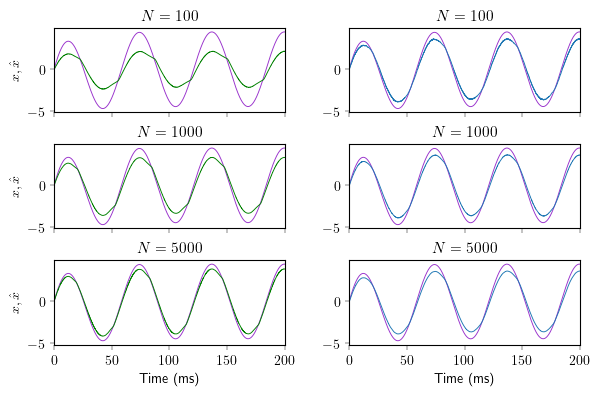

In [17]:
compare_sims_Nscal=[spikeM_sc2,spikeM_sc2_1k,spikeM_sc2_5k]
compare_sims_Nscal2=[spikeM_sc1,spikeM_sc1_1k,spikeM_sc1_5k]
fig, axs=plt.subplots(3,2, sharex=True, figsize=[full_width,2/3*full_width])

for i, sim_i in enumerate(compare_sims_Nscal):
    #ax_l=axs[i,0] xxx
    show_xlabel=True if i//2 else 'y'
    plotNetPerf(sim_i,ax=axs[i,0],show_label_ax=show_xlabel,col='g',show_legend=False)
    axs[i,0].set_title(fr'$N={sim_i.nNeur}$')
    show_xlabel='x' if i//2 else False
    plotNetPerf(compare_sims_Nscal2[i],ax=axs[i,1],show_label_ax=show_xlabel,show_legend=False)
    axs[i,1].set_title(fr'$N={sim_i.nNeur}$')
fig.tight_layout(w_pad=2,h_pad=0.5)
#plt.savefig(os.path.join(SAVEFIG_PATH,'Nscal'),bbox_inches='tight',dpi=300)   


# Poisson rate model

In [18]:
cos_input=lambda t: input_cos(t,ampl=0.1)
spikeM_cos=spikeMod_sim(**setPar(input_fct=cos_input))
rateM_cos=rateMod_sim_fast(**setPar(input_fct=cos_input))


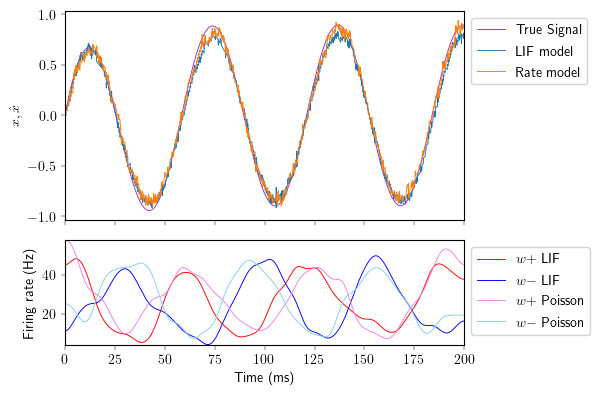

In [19]:
fig, axs=plt.subplots(2,1, sharex=True,figsize=[full_width,2/3*full_width],
                      gridspec_kw={'height_ratios': [2,1]},dpi=100)

plotNetPerf(spikeM_cos,axs[0],name1='LIF model',sim2=rateM_cos,name2='Rate model',
            show_label_ax='y',show_title=False)
pltSmoothedRates(spikeM_cos,sim2=rateM_cos,ax=axs[1],sig=400,show_title=False)
fig.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'rate_vs_spike1'),bbox_inches='tight',dpi=300)   

## Test for different inputs

In [20]:
spikeM_slow=spikeMod_sim(**setPar(input_fct=lambda t: input_cos(t,freq=0.05),sigma_V=0.5))
rateM_slow=rateMod_sim_fast(**setPar(input_fct=lambda t: input_cos(t,freq=0.05),sigma_V=0.5))
spikeM_fast=spikeMod_sim(**setPar(input_fct=lambda t: input_cos(t,freq=0.2,ampl=0.2),sigma_V=0.5))
rateM_fast=rateMod_sim_fast(**setPar(input_fct=lambda t: input_cos(t,freq=0.2,ampl=0.2),sigma_V=0.5))
spikeM_quiesc=spikeMod_sim(**setPar(input_fct=input_0,sigma_V=0.5))
rateM_quiesc=rateMod_sim_fast(**setPar(input_fct=input_0,sigma_V=0.5))
spikeM_high=spikeMod_sim(**setPar(input_fct=lambda t: input_cos(t,ampl=3),sigma_V=0.5))
rateM_high=rateMod_sim_fast(**setPar(input_fct=lambda t: input_cos(t,ampl=3),sigma_V=0.5))

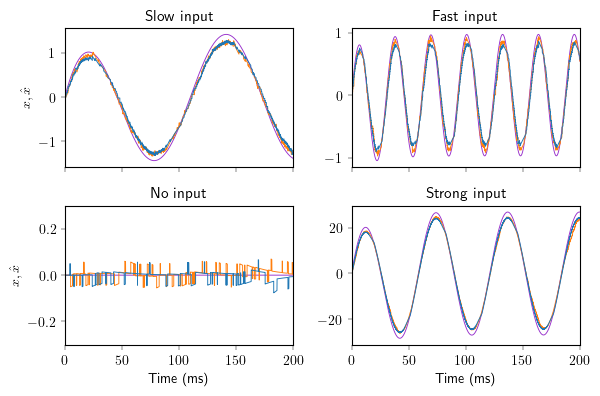

In [21]:
fig, axs = plt.subplots(2,2,sharex=True)
plotNetPerf(rateM_slow,ax=axs[0,0],sim2=spikeM_slow,show_legend=False,
            show_label_ax='y',show_title=False)
axs[0,0].set_title('Slow input')
plotNetPerf(rateM_fast,ax=axs[0,1],sim2=spikeM_fast,show_legend=False,
            show_label_ax=False,show_title=False)
axs[0,1].set_title('Fast input')
plotNetPerf(rateM_quiesc,ax=axs[1,0],sim2=spikeM_quiesc,show_legend=False,
            show_label_ax='all',show_title=False)
axs[1,0].set_title('No input')
axs[1,0].set_ylim(-0.3,0.3)
plotNetPerf(rateM_high,ax=axs[1,1],sim2=spikeM_high,show_legend=False,
            show_label_ax='x',show_title=False)
axs[1,1].set_title('Strong input')

plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'poiss_test_diff_s'),bbox_inches='tight',dpi=300)

## Match tau

In [22]:
params_fast={'input_fct':lambda t: input_cos(t,freq=0.2,ampl=0.2),'sigma_V':0.5}

In [23]:
rateM_fast_tau1=rateMod_sim_fast(**setPar(tau=1,asynchr=True,sparse=True,**params_fast))
rateM_fast_tau15=rateMod_sim_fast(**setPar(tau=15,sparse=True,**params_fast))
rateM_fast_tau30=rateMod_sim_fast(**setPar(tau=30,sparse=True,**params_fast))

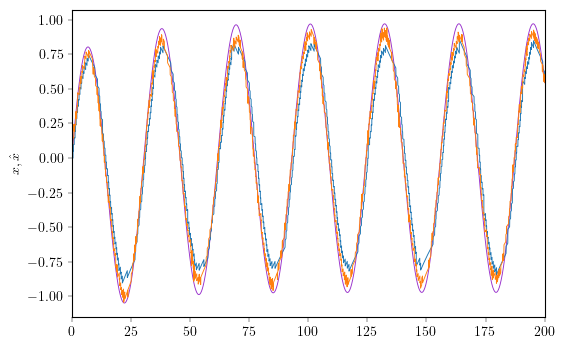

In [24]:
plotNetPerf(spikeM_fast,name1='LIF model',sim2=rateM_fast_tau1,name2='Rate model',
            show_label_ax='y',show_title=False,show_legend=False)


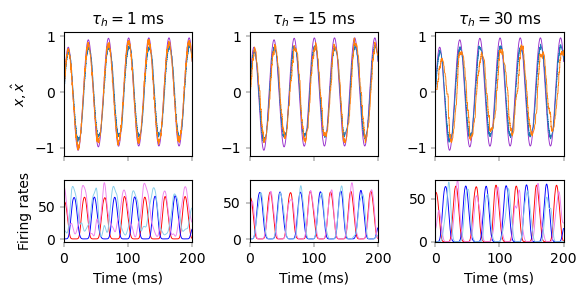

In [25]:
compare_sims_tau=[rateM_fast_tau1,rateM_fast_tau15,rateM_fast_tau30]
fig, axs=plt.subplots(2,3, sharex=True, figsize=[full_width,1/2*full_width],
                      gridspec_kw={'height_ratios': [2,1]})

for i, sim_i in enumerate(compare_sims_tau):
    plotNetPerf(spikeM_fast,axs[0,i],name1='LIF model',sim2=sim_i,name2='Rate model',
            show_label_ax=None,show_title=False,show_legend=False)
    axs[0,i].set_title(fr'$\tau_h={sim_i.tau}$ ms')
    pltSmoothedRates(spikeM_fast,sim2=sim_i,ax=axs[1,i],sig=200,show_title=False,
                show_label_ax='x',show_legend=False)
    
axs[0,0].set_ylabel(r'$x,\hat x$')
axs[1,0].set_ylabel('Firing rates')

fig.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'fastInput_vs_tau'),bbox_inches='tight',dpi=300)   


### Dependance on $\tau_h$

In [26]:
vis_input=lambda t: input_cst(t,1)
vis_pars={'asynchr':False,'nNeur':1000,'sigma_V':0.5,'T':500,'connStrength':5,'input_fct':vis_input}
tau1_cst= rateMod_sim_fast(**setPar(tau=1,**vis_pars))
tau30_cst= rateMod_sim_fast(**setPar(tau=30,**vis_pars))
spikeM_cst=spikeMod_sim(**setPar(**vis_pars))

In [27]:
tau_vals1=[1,2.5,5,7.5,10,12.5,15,17.5,20]
baseM_match= rateMod_sim_fast(**setPar(sigma_V=0.5,T=500))
baseM_match_1k= rateMod_sim_fast(**setPar(sigma_V=0.5,nNeur=1000,T=500))

In [29]:
with open('data/res_tau_1409', 'rb') as fp:
    dict_res0=pickle.load(fp)
for key,val in dict_res0.items():
        exec(key + '=val')

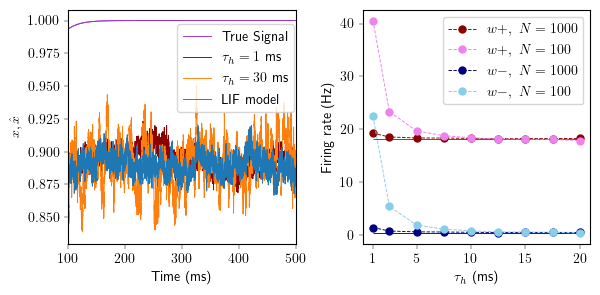

In [39]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=[full_width,full_width/2])
plotNetPerf(tau1_cst,ax=ax1,col='darkred',cutoff=100,
            name1=r'$\tau_h=1$ ms',sim2=tau30_cst,col2='C1',
           name2=r'$\tau_h=30$ ms',show_legend=False,show_title=False)
plotNetPerf(spikeM_cst,ax=ax1,cutoff=100,col='C0',
            name1='LIF model',show_legend=False,show_title=False)
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(),loc='center left',bbox_to_anchor=(0.45,0.75))
_=ax2.hlines(fr_plus_lif_1k,tau_vals1[0],tau_vals1[-1],'r','-')
_=ax2.plot(tau_vals1,fr_plus_r_1k,'--o',c='darkred',markersize=5,label=r'$w+,\ N=1000$')
_=ax2.plot(tau_vals1,fr_plus_r,'--o',c='violet',markersize=5,    label=r'$w+,\ N=100$')
_=ax2.hlines(fr_minus_lif_1k,tau_vals1[0],tau_vals1[-1],'b','-')
_=ax2.plot(tau_vals1,fr_minus_r_1k,'--o',c='navy',markersize=5,  label=r'$w-,\ N=1000$')
_=ax2.plot(tau_vals1,fr_minus_r,'--o',c='skyblue',markersize=5,  label=r'$w-,\ N=100$')
_=ax2.set_xticks(tau_vals1[::2])
ax2.legend()
ax2.set_ylabel('Firing rate (Hz)')
ax2.set_xlabel(r'$\tau_h$ (ms)')
plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'diff_tau_stat'),bbox_inches='tight',dpi=300)   


### Dependance on signal strength

In [40]:
x_grid=np.arange(0,6,1)
tau_vals=[1,5,10]

In [42]:
with open('data/pois_vs_lif_vs_x_2509', 'rb') as fp:
    dict_res1=pickle.load(fp)
for key,val in dict_res1.items():
        exec(key + '=val')

In [45]:
fr_sim1,cv_sim1,mean_sim1,var_sim1=res_sim1
fr_sim1_1k,cv_sim1_1k,mean_sim1_1k,var_sim1_1k=res_sim1_1k
fr_sim1_lif,cv_sim1_lif,mean_sim1_lif,var_sim1_lif=lif_sim1
fr_sim1_lif_1k,cv_sim1_lif_1k,mean_sim1_lif_1k,var_sim1_lif_1k=lif_sim1_1k

In [46]:
fr_sim2,       cv_sim2,       mean_sim2,       var_sim2        = res_sim2
fr_sim2_1k,    cv_sim2_1k,    mean_sim2_1k,    var_sim2_1k     = res_sim2_1k
fr_sim2_lif,   cv_sim2_lif,   mean_sim2_lif,   var_sim2_lif    = lif_sim2
fr_sim2_lif_1k,cv_sim2_lif_1k,mean_sim2_lif_1k,var_sim2_lif_1k = lif_sim2_1k

In [47]:
cols_p=plt.get_cmap('hot')

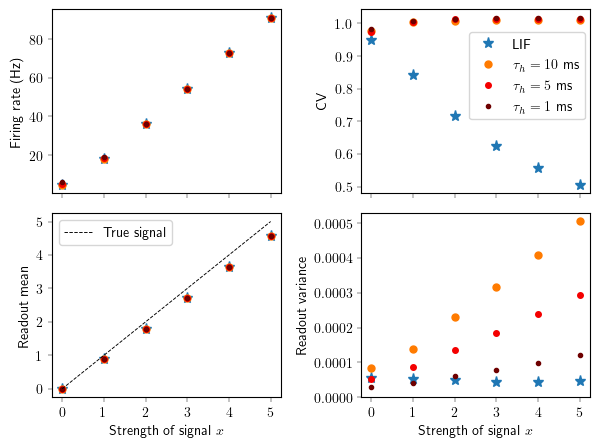

In [48]:
fig, axs =plt.subplots(2,2,sharex=True,figsize=[full_width,3*full_width/4])

plot_list_lif=[fr_sim1_lif_1k[:,0], cv_sim1_lif_1k, mean_sim1_lif_1k, var_sim1_lif_1k]
plot_list_p=[fr_sim1_1k[:,:,0], cv_sim1_1k, mean_sim1_1k, var_sim1_1k]
y_labels=['Firing rate (Hz)', 'CV', 'Readout mean', 'Readout variance']
for i, ax in enumerate(axs.reshape(-1)):
    lif_line,=ax.plot(x_grid,plot_list_lif[i],'*',c=col_lif,markersize=8,label='LIF')
    for j, tau in enumerate(tau_vals[::-1]):
        j=len(tau_vals)-j-1
        _=ax.plot(x_grid,plot_list_p[i][:,j], 'o',markersize=3+j,c=cols_p(0.15+j/5),label=fr'$\tau_h={tau_vals[j]}$ ms')
    ax.set_ylabel(y_labels[i])

for lower_ax in axs[1,:]:
    lower_ax.set_xlabel(r'Strength of signal  $x$')
    lower_ax.set_xticks(x_grid)
axs[1,1].set_ylim(0)    
l_mean,=axs[1,0].plot(x_grid,'k--',label='True signal')
axs[1,0].legend([l_mean],['True signal'])
handles, labels = axs[0,0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0,1].legend(by_label.values(), by_label.keys(),bbox_to_anchor=[0.44,0.64])
plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'match_pois_vs_lif'),bbox_inches='tight',dpi=300)   

#### Results for higher noise: $\sigma_V=1$

In [49]:
sim2_pars=setPar(sigma_V=1,T=5000)
baseM_sim2=rateMod_sim_fast(sparse=True,manualSim=True,**sim2_pars)

sim2_pars_1k=setPar(sigma_V=1,T=5000,nNeur=1000)
baseM_sim2_1k=rateMod_sim_fast(sparse=True,manualSim=True,**sim2_pars_1k)

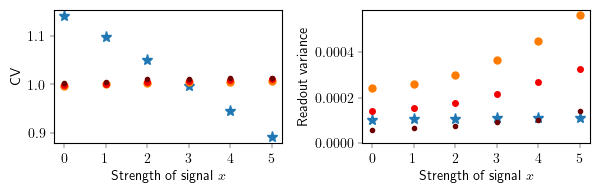

In [50]:
fig, axs =plt.subplots(1,2,figsize=[full_width,full_width/3])

plot_list_lif=[cv_sim2_lif_1k, var_sim2_lif_1k]
plot_list_p=[cv_sim2_1k, var_sim2_1k]
y_labels=['CV', 'Readout variance']
for i, ax in enumerate(axs):
    lif_line,=ax.plot(x_grid,plot_list_lif[i],'*',c=col_lif,markersize=8,label='LIF model')
    for j, tau in enumerate(tau_vals[::-1]):
        j=len(tau_vals)-j-1
        _=ax.plot(x_grid,plot_list_p[i][:,j], 'o',markersize=3+j,c=cols_p(0.15+j/5),label=fr'$\tau_h={tau_vals[j]}$ ms')
    ax.set_ylabel(y_labels[i])
    ax.set_xlabel(r'Strength of signal  $x$')
    ax.set_xticks(x_grid)
axs[1].set_ylim(0)
#handles, labels = axs[0,0].get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#axs[0,1].legend(by_label.values(), by_label.keys(),bbox_to_anchor=[0.45,0.58],borderpad=0.1)
plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'pois_vs_lif_sig1'),bbox_inches='tight',dpi=300)   

# Mean-field results

## Readout mean

In [60]:
with open('data/res_mf_means_2509', 'rb') as fp:
    dict_res2=pickle.load(fp)
for key,val in dict_res2.items():
        exec(key + '=val')

In [61]:
fr_simN_lif,   cv_simN_lif,   mean_simN_lif,   var_simN_lif    = lif_simN
fr_simN_p,   cv_simN_p,   mean_simN_p,   var_simN_p    = p_simN

In [62]:
spikeM=spikeMod_sim(**setPar(input_fct=lambda t: input_cst(t,1),connStrength=3,sigma_V=0.5))
def plt2mean_rels(pc_sim,ax=None):
    if ax==None: ax=plt.gca()
    mean_q_grid = np.arange(-0.1,0.1,0.001)
    first_rel_mean_x= first_mean_rel(pc_sim, mean_q_grid)
    second_rel_mean_x = second_mean_rel(pc_sim, mean_q_grid)
    ax.plot(mean_q_grid,first_rel_mean_x, 'C1',label='First relation')
    ax.plot(mean_q_grid,second_rel_mean_x,'C2', label='Second relation')
    ax.hlines(mean_est_sim(pc_sim),mean_q_grid[0],mean_q_grid[-1],linestyles='--', label='LIF simulation')
    #ax.legend()
    ax.set_ylabel(r'$\langle \hat x \rangle$')
    ax.set_xlabel(r'$\langle q \rangle$')

In [63]:
def plt_mf_means(x_grid,mean_sims,means_anal,ax=None):
    if ax==None: ax=plt.gca()
    ax.plot(x_grid,x_grid,'k--', label='True signal x')
    ax.plot(x_grid,means_anal, 'orange', label='Analytical prediction')
    ax.plot(x_grid,mean_sims,'b*',markersize=5, label='Simulation results')
    ax.set_ylabel(r'$\langle \hat x \rangle$')
    ax.set_xlabel(r'$x$')
    #ax.legend()

Compute results for different signal strengths

In [54]:
res_means_anal=np.zeros(x_grid.size)
for i,s in enumerate(x_grid/20):
    res_means_anal[i]=calc_mf_means(baseM_sim1_1k,s)[0]

In [55]:
N_vals=np.append(100,np.arange(500,5001,500))
simN_pars_spec={'sigma_V':0.5,'T':1000}
simN_pars=setPar(**simN_pars_spec)

In [56]:
%%time
N_grid=np.arange(100,5000)
meansN_anal=np.zeros(N_grid.size)
for i,N in enumerate(N_grid):
    sim_i=gen_model(**setPar(nNeur=N,**simN_pars_spec))
    meansN_anal[i]=calc_mf_means(sim_i)[0]    

CPU times: user 13.2 s, sys: 261 ms, total: 13.5 s
Wall time: 13.5 s


Compute results for increasing $N$

In [57]:
def pltMeansN(N_grid,meansN_anal,mean_simN_p,N_vals,mean_simN,ax=None):
    if ax==None: ax=plt.gca()
    ax.plot(N_grid,meansN_anal,'orange',label='Theory')
    #plt.plot(N_grid[:t],res_means_N2[:t])
    ax.plot(N_vals,mean_simN_p[:,1],'C1o',markersize=3,label='Poisson simulation')
    ax.plot(N_vals,mean_simN_lif,'b*',markersize=5, label='LIF simulation')
    ax.set_xticks(N_vals[::2])
    ax.set_xlabel('Network size N')
    ax.set_ylabel(r'$\langle \hat x \rangle$')
#pltMeansN(N_grid,meansN_anal,mean_simN_p,N_vals,mean_simN_lif)

In [58]:
sim_i=gen_model(**setPar(nNeur=100,**simN_pars_spec))
calc_mf_means(sim_i)[0]   

array([0.86026395])

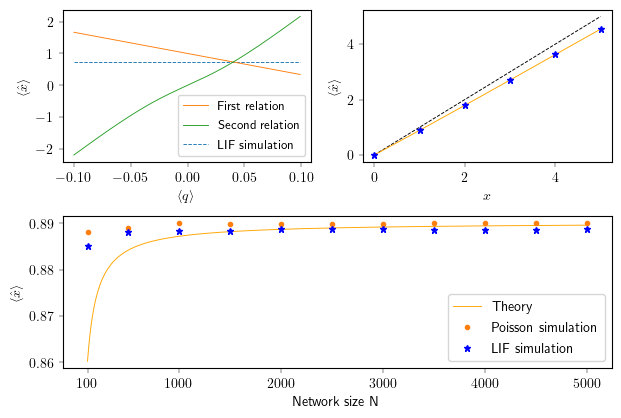

In [64]:
fig = plt.figure(constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax=fig.add_subplot(gs[0,0])
plt2mean_rels(spikeM)
ax.legend(fontsize=9)
ax=fig.add_subplot(gs[0,1])
plt_mf_means(x_grid,mean_sim1_lif_1k,res_means_anal)
ax = fig.add_subplot(gs[1,:])
pltMeansN(N_grid,meansN_anal,mean_simN_p,N_vals,mean_simN_lif,ax)
ax.legend()
#plt.savefig(os.path.join(SAVEFIG_PATH,'means_mf'),bbox_inches='tight',dpi=300)   

## Readout variance

### Variance for increasing network size

In [65]:
%%time
N_grid=np.arange(100,5000)
varN_anal=np.zeros([N_grid.size,len(tau_vals)])
for i,N in enumerate(N_grid):
    for j, tau in enumerate(tau_vals):
        sim_i=gen_model(**setPar(nNeur=N,**simN_pars_spec))
        varN_anal[i,j]=var_readout_anal(sim_i,tau_h=tau)
        

CPU times: user 42 s, sys: 594 ms, total: 42.6 s
Wall time: 42.7 s


In [66]:
def pltVarN(N_grid,varN_anal,mean_simN_p,N_vals,var_simN,ax=None):
    if ax==None: ax=plt.gca()
    ax.plot(N_grid,varN_anal[:,0],'orange',label='Theory')
    #plt.plot(N_grid[:t],res_var_N2[:t])
    ax.plot(N_vals,var_simN_p[:,0],'C1o',markersize=3,label='Poisson simulation')
    ax.plot(N_vals,var_simN_lif,'b*',markersize=5, label='LIF simulation')
    ax.set_xticks(N_vals[::2])
    ax.set_xlabel('Network size N')
    ax.set_ylabel(r'$\mathrm{Var}(\hat x)$')
#pltVarN(N_grid,varN_anal,var_simN_p,N_vals,var_simN_lif)

Compute variance for increasing signal strength

In [67]:
x_grid_anal=np.arange(x_grid[0],x_grid[-1]+1e-10,0.01)
def anal_var_vs_s(grid=x_grid_anal,**simArgs):
    pc_sim=gen_model(**setPar(**simArgs))
    res=np.array([var_readout_anal(pc_sim,s=x/20) for x in grid])
    return res

In [68]:
%%time
var_anal_tau=np.zeros([x_grid_anal.size,len(tau_vals)])
var_anal_tau_1k=np.zeros([x_grid_anal.size,len(tau_vals)])
for j, tau in enumerate(tau_vals):
    var_anal_tau[:,j]=anal_var_vs_s(tau=tau,**sim1_pars_spec)
    var_anal_tau_1k[:,j]=anal_var_vs_s(nNeur=1000,tau=tau,**sim1_pars_spec)

sig_vals=[0.5,1,1.5]
var_anal_sig=np.zeros([x_grid_anal.size,len(tau_vals)])
var_anal_sig_1k=np.zeros([x_grid_anal.size,len(tau_vals)])
for j, sig in enumerate(sig_vals):
    var_anal_sig[:,j]=anal_var_vs_s(sigma_V=sig,nNeur=100,tau=5)
    var_anal_sig_1k[:,j]=anal_var_vs_s(sigma_V=sig,nNeur=1000,tau=5)


CPU times: user 16.6 s, sys: 179 ms, total: 16.8 s
Wall time: 16.7 s


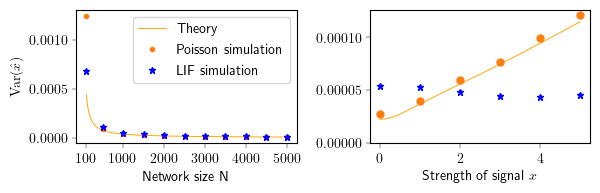

In [69]:
fig,axs =plt.subplots(1,2,figsize=[full_width,full_width/3])

pltVarN(N_grid,varN_anal,var_simN_p,N_vals,var_simN_lif,axs[0])
axs[0].legend()
col_lif='b'
col_p='C1'
col_anal='orange'
axs[1].plot(x_grid_anal, var_anal_tau_1k[:,0], color=col_anal,markersize=5, label='Theory, N=1000')
axs[1].plot(x_grid, var_sim1_lif_1k,'*',color=col_lif, markersize=5, label='LIF model, N=1000')
axs[1].plot(x_grid, var_sim1_1k[:,0],'o',color=col_p, markersize=5, label='Poisson model, N=1000')
axs[1].set_ylim(0)
axs[1].set_xlabel(r'Strength of signal  $x$')

plt.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'mf_vs_N'),bbox_inches='tight',dpi=300)   

### Dependance of readout variance on time-scale and external noise

In [70]:
with open('data/res_var3_2609','rb') as fp:
    dict_res_var3=pickle.load(fp)
for key,val in dict_res_var3.items():
        exec(key + '=val')

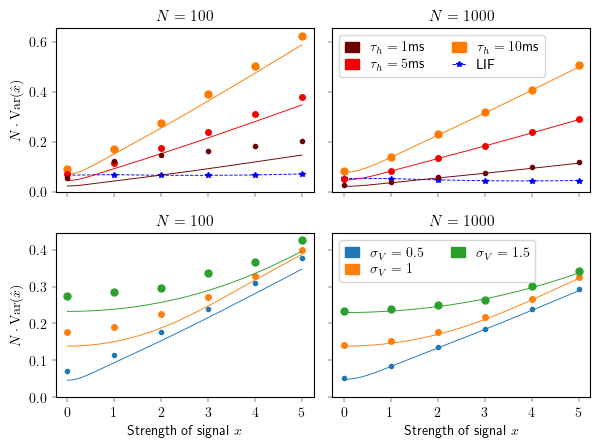

In [72]:
fig,axs =plt.subplots(2,2,sharey='row', sharex=True,figsize=[full_width,3*full_width/4])

plot_list_tau_lif=[var_sim1_lif, var_sim1_lif_1k]
plot_list_tau_p=[var_sim1,var_sim1_1k]
plot_list_tau_anal=[var_anal_tau,var_anal_tau_1k]
plot_list_N=[100,1000]

for i, ax in enumerate(axs[0]):
    lif_line,=ax.plot(x_grid,plot_list_tau_lif[i]*plot_list_N[i],'*--',
               c=col_lif,markersize=4,label='LIF')
    for j, tau in enumerate(tau_vals[::-1]):
        j=len(tau_vals)-j-1
        _=ax.plot(x_grid,plot_list_tau_p[i][:,j]*plot_list_N[i], 'o',markersize=3+j,
                  c=cols_p(0.15+j/5),label=fr'$\tau_h={tau_vals[j]}$ ms')
        _=ax.plot(x_grid_anal,plot_list_tau_anal[i][:,j]*plot_list_N[i],
                  c=cols_p(0.15+j/5),label=fr'$\tau_h={tau_vals[j]}$ ms')

patch_tau1 = mpatches.Patch(color=cols_p(0.15), label=r'$\tau_h=1$ms')
patch_tau2 = mpatches.Patch(color=cols_p(0.15+1/5), label=r'$\tau_h=5$ms')
patch_tau3 = mpatches.Patch(color=cols_p(0.15+2/5), label=r'$\tau_h=10$ms')  
ax.legend(handles=[patch_tau1,patch_tau2,patch_tau3,lif_line],ncol=2, handlelength=1,
         labelspacing=0.2)

plot_list_sig_lif= [[var_sim1_lif,var_sim2_lif,lif_var3], 
                    [var_sim1_lif_1k,var_sim2_lif_1k,lif_var3_1k]]
plot_list_sig_p=   [[var_sim1,var_sim2,var3],[var_sim1_1k,var_sim2_1k,var3_1k]]
plot_list_sig_anal=[var_anal_sig,var_anal_sig_1k]
sig_cols=['C0','C1','C2']
for i, ax in enumerate(axs[1]):
    for j, sig in enumerate(sig_vals):
        _=ax.plot(x_grid,plot_list_sig_p[i][j][:,1]*plot_list_N[i], 'o',markersize=3+j,
                  c=sig_cols[j],label=fr'$\sigma_V={sig_vals[j]}$ ms')
        _=ax.plot(x_grid_anal,plot_list_sig_anal[i][:,j]*plot_list_N[i],
                  c=sig_cols[j],label=fr'$\sigma_V={sig_vals[j]}$ ms')
    ax.set_xlabel(r'Strength of signal  $x$')
    ax.set_xticks(x_grid)
    
col1_patch = mpatches.Patch(color='C0', label=r'$\sigma_V=0.5$')
col2_patch = mpatches.Patch(color='C1', label=r'$\sigma_V=1$')
col3_patch = mpatches.Patch(color='C2', label=r'$\sigma_V=1.5$')  
ax.legend(handles=[col1_patch,col2_patch,col3_patch],ncol=2, handlelength=1,
         labelspacing=0.2)

for i, ax in enumerate(axs.reshape(-1)):
    if (i+1)%2: ax.set_ylabel(r'$N\cdot\mathrm{Var}(\hat x)$')
    ax.set_ylim(0)
    ax.set_title(fr'$N={plot_list_N[i%2]}$')
fig.tight_layout()
#plt.savefig(os.path.join(SAVEFIG_PATH,'mf_tau_sig'),bbox_inches='tight',dpi=300)   
